In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import os
import numpy as np
import scanpy as sc
import PyWGCNA
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import mannwhitneyu, false_discovery_control
import re
from itertools import combinations
from scipy.stats import pearsonr
import ast

In [3]:
def stack_triangle(df, col):
    df = pd.DataFrame(
        df.where(
            np.tri(
                df.shape[0],
                dtype=bool,
                k=-1
            ),
            np.nan
        ).stack(dropna=True), columns=[col] 
    )
    
    return df


In [4]:
# Function that generates and saves the ROC curve
def generate_roc_curve(
    data,
    target_col,
    feature_col,
):
    # ROC curve using all gene pairs
    fpr, tpr, thr = roc_curve(data[target_col], data[feature_col])
    auroc = roc_auc_score(data[target_col], data[feature_col])
    
    return fpr, tpr, thr, auroc

In [5]:
def fig_to_panels(fig, axes, output_dir):
    # Save individual panels of a figure 
    
    for panel_name, ax in axes.items():
        # Extract the panel title
        panel_title = ax.get_title()

        # Sanitize the panel title to use in filenames
        safe_title = panel_title.replace(" ", "_").replace("/", "_").replace("\n", "_").lower()

        # Create the filename for the current panel
        output_file = os.path.join(output_dir,safe_title)

        # Adjust the bounding box to include everything (labels, titles, etc.)
        extent = ax.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())

        # Save the individual panel using the adjusted bounding box
        fig.savefig(output_file + '.pdf', bbox_inches=extent, dpi=300)
        fig.savefig(output_file + '.png', bbox_inches=extent)

        print(f"Saved panel '{panel_title}' to {output_file}")


In [6]:
# Define colors
# Light version is obtained by setting alpha=0.5

ncolor  = '#00728eff' # solid dark
ncolor2 = '#00728e80' # alpha=0.5
lightncolor = '#7fb8c6ff' # solid light

tcolor  = '#ab3502ff'
tcolor2 = '#ab350280'
lighttcolor = '#d49980ff'

graycolor = '#4D4E4FFF'
graycolor2 ='#4d4e4f80'

lightgray = '#C8CAD4'

orangecolor = '#e69426'
orangecolor2 = '#e6942680'
lightorangecolor = '#f2c992ff'

In [7]:
def network_to_adj(network_path):
    network = pd.read_csv(
        network_path,
        usecols=['complex1', 'complex2', 'adj']
    )

    # Add a mirrored version of the network to make it symmetric
    network_mirrored = network.copy()
    network_mirrored.columns = ['complex2', 'complex1', 'adj']
    network = pd.concat([network, network_mirrored], ignore_index=True)

    adj = network.pivot(index='complex1', columns='complex2', values='adj').fillna(0)
    return adj

# Hub Genes

In [8]:
import pandas as pd
import numpy as np
import os
from scipy.stats import mannwhitneyu, false_discovery_control

In [9]:
hubdf = pd.read_csv('/home/lnemati/pathway_crosstalk/results/hubs/n_tissues_top_node_metrics.csv', index_col=0)

#top_ccc = df[df['interactor'].astype(bool)][['f_degree_tumor', 'f_degree_normal']]
#top_ccc['sum'] = top_ccc['f_degree_tumor'] + top_ccc['f_degree_normal']
#top_ccc.sort_values(by='f_degree_tumor', ascending=False).head(20)

In [10]:
def find_files(filename, search_path):
    result = []
    for root, dirs, files in os.walk(search_path):
        if filename in files:
            result.append(os.path.join(root, filename))
    return result

def hub_connectivities(root_only=True):
    
    if root_only:
        filename = 'hubs_connectivities_root.csv'
    else:
        #filename = 'hubs_connectivities_all.csv'
        filename = 'hubs_connectivities_hallmarks.csv'

    # Example usage:
    search_path = '/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal'
    matches = find_files(filename, search_path)    

    pw_genes   = {}
    name_to_id = {}
    id_to_name = {}

    #with open('/home/lnemati/resources/reactome/ReactomePathways.gmt', 'r') as f:
    #    for line in f.readlines():
    #        line = line.split('\t')
    #        name_to_id[line[0]] = line[1]
    #        id_to_name[line[1]] = line[0]
    #        pw_genes[line[0]] = line[2:]
    #  
    #ndf = pd.DataFrame(columns=id_to_name.values())
    #tdf = pd.DataFrame(columns=id_to_name.values())
    
    pw_genes   = {}
    name_to_id = {}
    id_to_name = {}

    with open('/home/lnemati/resources/msigdb_hallmarks/h.all.v2024.1.Hs.symbols.gmt', 'r') as f:
        for line in f.readlines():
            line = line.split('\t')
            name_to_id[line[0]] = line[1]
            id_to_name[line[1]] = line[0]
            pw_genes[line[0]] = line[2:]

    ndf = pd.DataFrame(columns=id_to_name.values())
    tdf = pd.DataFrame(columns=id_to_name.values())

     
    if root_only:
        root_pws = pd.read_csv('/home/lnemati/resources/reactome/ReactomeRootPathways.csv')
        root_pws = root_pws['root'].map(id_to_name).unique()

        ndf = ndf[root_pws]
        tdf = tdf[root_pws]

        #ndf = pd.DataFrame(columns=root_pws)
        #tdf = pd.DataFrame(columns=root_pws)

    for match in matches:
        if '/normal/' in match:
            row = pd.read_csv(match, index_col=0).T
            row['subtissue'] = [match.split('/')[-2]]
            row['tissue'] = [match.split('/')[-4]]
            ndf = pd.concat([ndf, row])
        elif '/tumor/' in match:
            row = pd.read_csv(match, index_col=0).T
            row.index = [match.split('/')[-2]]
            row['subtissue'] = [match.split('/')[-2]]
            row['tissue'] = [match.split('/')[-4]]
            tdf = pd.concat([tdf, row])

    ndf = ndf.set_index('subtissue', drop=True)
    tdf = tdf.set_index('subtissue', drop=True)
    
    ndf = ndf.groupby('tissue').median()
    tdf = tdf.groupby('tissue').median()

    ndf['Condition'] = 'normal'
    tdf['Condition'] = 'tumor'
    
    df = pd.concat([ndf, tdf])

    # Reset index to preserve tissue information
    df = df.reset_index()
    
    # Reshape the DataFrame to a long format suitable for violin plots
    df = pd.melt(df, id_vars=['Condition', 'tissue'], var_name='Pathway', value_name='connection_strength')
    df = df.set_index('tissue')
    
    #df_long['connection_strength'] = np.log(df_long['connection_strength'])
    
    order = df.drop(columns='Condition').groupby('Pathway').mean().sort_values(by='connection_strength', ascending=False).index
    
    # Initialize an empty dictionary to store the results
    pvals = {}

    # Get unique pathways
    pathways = df['Pathway'].unique()

    # Loop through each pathway
    for pathway in pathways:
        # Subset the data for the current pathway
        subset = df[df['Pathway'] == pathway]

        # Split into normal and tumor conditions
        normal = subset[subset['Condition'] == 'normal']['connection_strength']
        tumor = subset[subset['Condition'] == 'tumor']['connection_strength']

        # Perform Mann-Whitney U test
        stat, p_value = mannwhitneyu(normal, tumor, alternative='two-sided')

        # Store the p-value in the dictionary with pathway as the key
        pvals[pathway] = p_value

    # Convert the dictionary to a pandas Series
    pvals = pd.Series(pvals, name='pvals')
    pvals = pvals.loc[order]
    pvals.loc[order] = false_discovery_control(pvals, method='bh')

    return df, pvals

In [11]:
def find_files(filename, search_path):
    result = []
    for root, dirs, files in os.walk(search_path):
        if filename in files:
            result.append(os.path.join(root, filename))
    return result

filename = 'hubs_connectivities_hallmarks.csv'

# Example usage:
search_path = '/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal'
matches = find_files(filename, search_path)    

In [12]:
connect, connect_pvals = hub_connectivities(root_only=False)

In [13]:
connect.to_csv('/home/lnemati/pathway_crosstalk/results/hubs/hubs_connectivities_hallmarks.csv')

In [14]:
hubdf[['f_degree_tumor', 'f_degree_normal']].to_csv('/home/lnemati/pathway_crosstalk/results/hubs/hubs_in_tissues_frequencies.csv')

In [15]:
import textwrap

def plot_pathway_connectivity(df, pvals, top_N=None, significance=None, ax=None):
    """
    Plots the pathway connectivity for normal and tumor groups and adds significance bars.
    
    Arguments:
    df : DataFrame
        The dataframe containing the data for plotting. It must have 'Pathway', 'connection_strength', and 'condition' columns.
    pvals : Series
        A Series where the index is the pathway names and the values are the p-values.
    savepath : str, optional
        The path where the plot will be saved. If None, the plot will not be saved. Default is None.
    significance : float or None, optional
        The maximum p-value to consider a pathway significant. If None, plot all pathways. Default is None.
    """
        
    # Define a function to add significance stars
    def add_significance_bar(x1, x2, y, h, significance, ax):
        """
        Add significance bar with stars between two boxplots.

        x1, x2: Positions of the two groups (normal/tumor).
        y: Height where the bar is placed.
        h: Height of the bar itself.
        significance: The star to place based on p-value.
        ax: The axis object to annotate on.
        """
        ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c='black')
        ax.text((x1 + x2) * .5, y + h, significance, ha='center', va='bottom', color='black')

    # Filter pathways based on the significance threshold if provided
    if significance is not None:
        significant_pathways = pvals[pvals < significance].index
        df = df[df['Pathway'].isin(significant_pathways)]
        order = significant_pathways
    else:
        order = pvals.index
        
    if top_N is not None:
        order = order[:top_N]
        df = df[df['Pathway'].isin(order)]

    # Shorten long pathway labels
    def shorten_label(label, max_length=40):
        """Truncates or wraps a label if it exceeds max_length."""
        if len(label) > max_length:
            return '\n'.join(textwrap.wrap(label, max_length))
        return label

    shortened_labels = [shorten_label(pathway, max_length=60) for pathway in order]

    # Create the boxplot
    palette = {'normal': ncolor, 'tumor': tcolor}  # assume ncolor and tcolor are pre-defined
    if ax is None:
        ax = sns.boxplot(
            x='Pathway',
            y='connection_strength',
            hue='Condition',
            data=df,
            order=order,
            palette=palette,
            showfliers=False,
        )
    else:
        sns.boxplot(
            #x='Pathway',
            #y='connection_strength',
            x='Pathway',
            y='connection_strength',
            hue='Condition',
            data=df,
            order=order,
            palette=palette,
            showfliers=False,
            ax=ax
        )

    ax.set_ylabel('connection_strength')
    ax.set_xticklabels(shortened_labels)  # Update x-tick labels
    plt.xticks(rotation=90, ha='center')  # Rotate for better visibility

    # Add significance bars and stars for each pathway
    for i, pathway in enumerate(order):
        # Get the p-value for the current pathway from the pvals Series
        pval = pvals[pathway]

        # Determine significance level
        if pval < 0.001:
            stars = '***'
        elif pval < 0.01:
            stars = '**'
        elif pval < 0.05:
            stars = '*'
        else:
            stars = 'ns'  # no significance

        # Find the maximum y-value for the current pathway to position the bars
        y_max = df[df['Pathway'] == pathway]['connection_strength'].max()

        # Get positions of normal and tumor groups (the boxplot positions)
        width = 0.4
        x1 = i - width  # position of normal (left side)
        x2 = i + width  # position of tumor (right side)

        # Add the significance bar if it's below the significance threshold (if provided)
        if stars != 'ns' and (significance is None or pval < significance):
            add_significance_bar(x1, x2, y_max + 0.01, 0.02, stars, ax)

    # Adjust layout to fit labels
    plt.ylim(0, 0.15)

# Call the function
#plot_pathway_connectivity(connect, pvals, top_N=100, significance=0.05)


In [16]:
import textwrap
import matplotlib.pyplot as plt
import seaborn as sns

def plot_pathway_connectivity_reduced(df, pvals, top_N=None, significance=None, ax=None):
    fs=16
    
    """
    Plots the pathway connectivity for normal and tumor groups and adds significance bars at a uniform y-position.
    
    Arguments:
    df : DataFrame
        Must have 'Pathway', 'connection_strength', and 'Condition' columns.
    pvals : Series
        Series with pathway names as index and p-values as values.
    top_N : int or None
        Number of top pathways to plot. Default is None.
    significance : float or None
        Maximum p-value to consider a pathway significant. Default is None.
    ax : matplotlib axis, optional
        If provided, plot on this axis.
    """

    def add_significance_bar(x1, x2, y, h, significance, ax):
        ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c='black')
        ax.text((x1 + x2) * 0.5, y + h, significance, ha='center', va='bottom', color='black')

    if significance is not None:
        significant_pathways = pvals[pvals < significance].index
        df = df[df['Pathway'].isin(significant_pathways)]
        order = significant_pathways
    else:
        order = pvals.index

    if top_N is not None:
        order = order[:top_N]
        df = df[df['Pathway'].isin(order)]

    def shorten_label(label, max_length=60):
        return '\n'.join(textwrap.wrap(label, max_length)) if len(label) > max_length else label

    shortened_labels = [shorten_label(pathway, max_length=60) for pathway in order]

    palette = {'normal': ncolor, 'tumor': tcolor}  # Ensure ncolor and tcolor are defined

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    sns.boxplot(
        x='Pathway',
        y='connection_strength',
        hue='Condition',
        data=df,
        order=order,
        palette=palette,
        showfliers=False,
        ax=ax
    )

    ax.set_xlabel('Pathway', fontsize=fs)
    ax.set_ylabel('Hubs Connection Strength', fontsize=fs)
    ax.set_xticklabels(shortened_labels)
    plt.xticks(rotation=90, ha='center')

    # Use a fixed y position above the highest data point
    global_y_max = df['connection_strength'].max()
    bar_y = global_y_max + 0.005  # fixed base height
    bar_h = 0.003                # height of the significance bar

    for i, pathway in enumerate(order):
        pval = pvals[pathway]
        if pval < 0.001:
            stars = '***'
        elif pval < 0.01:
            stars = '**'
        elif pval < 0.05:
            stars = '*'
        else:
            stars = 'ns'

        x1 = i - 0.2
        x2 = i + 0.2

        if stars != 'ns' and (significance is None or pval < significance):
            add_significance_bar(x1, x2, bar_y, bar_h, stars, ax)

    #plt.ylim(0, bar_y + bar_h + 0.03)  # Ensure bars are visible
    
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(labelsize=fs)    
    # Capitalize legend labels
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, [label.capitalize() for label in labels], title='Condition', fontsize=fs, title_fontsize=fs)
    ax.set_title('Connectivity of Hub Genes to Pathways', fontsize=fs)
    
    #plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/hubs/pathways_significant_only.pdf', dpi=300, bbox_inches='tight')
    #plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/hubs/pathways_significant_only.png', dpi=300, bbox_inches='tight')


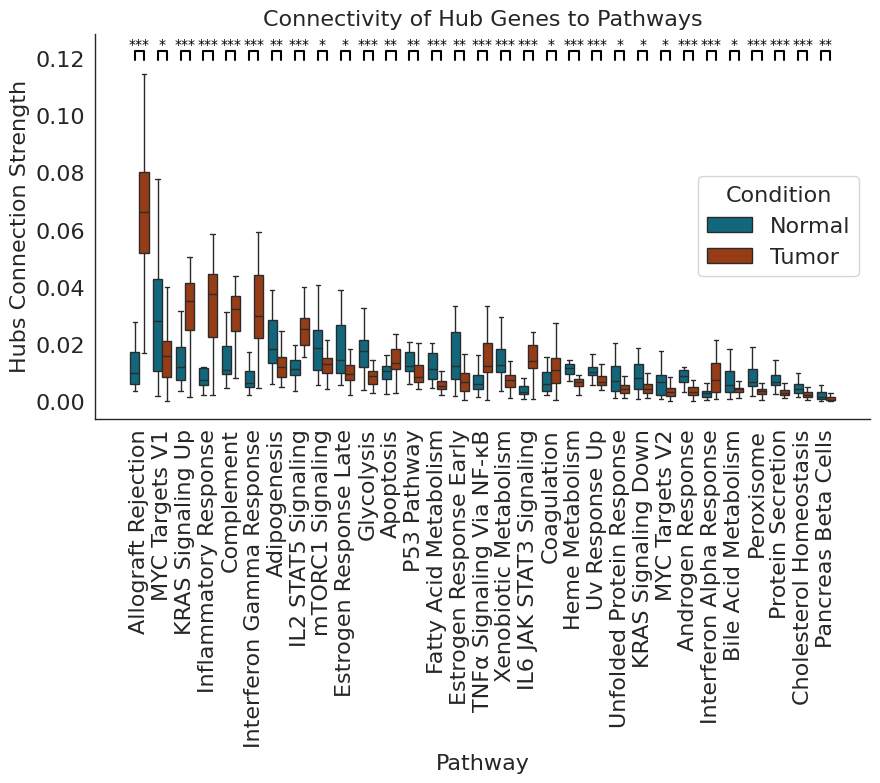

In [17]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
plot_pathway_connectivity_reduced(connect, connect_pvals, top_N=1000, significance=0.05, ax=ax) # there are 50 hallmarks, 31 have significant differences

labels = [tick.get_text() for tick in ax.get_xticklabels()]
labels = [label.replace('HALLMARK_', '').replace('_', ' ').title() for label in labels]

# Mapping for special gene/acronym capitalization

replace = {
    'Myc': 'MYC',
    'Kras': 'KRAS',
    'Il2': 'IL2',
    'Stat5': 'STAT5',
    'Il6': 'IL6',
    'Jak': 'JAK',
    'Stat3': 'STAT3',
    'P53': 'P53',
    'Tnfa': 'TNFα',
    'Nfkb': 'NF-κB',
    'Mtorc1': 'mTORC1',
    'Mtorc': 'mTORC',
    'Mtor': 'mTOR',
    ' Dn': ' Down',
    'Pi3K': 'PI3K',
    ' Akt': ' AKT'
}

for str1, str2 in replace.items():
    labels = [label.replace(str1, str2) for label in labels]

ax.set_xticklabels(labels)
plt.show()

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

hubdf = pd.read_csv('/home/lnemati/pathway_crosstalk/results/hubs/n_tissues_top_node_metrics.csv', index_col=0)

# Generate column names based on the metric
tumor_col = 'f_degree_tumor'
normal_col = 'f_degree_normal'

# Convert columns to numeric (ensuring proper conversion)
hubdf[tumor_col] = pd.to_numeric(hubdf[tumor_col], errors='coerce')
hubdf[normal_col] = pd.to_numeric(hubdf[normal_col], errors='coerce')

# Init Tumor Hubs DataFrame
tumor_hub_values = hubdf[tumor_col].dropna().unique()  # Drop NaNs before sorting
tumor_hub_hubdf = pd.DataFrame(index=sorted(tumor_hub_values, reverse=True), columns=['CCC', 'Other Genes'])

# Init Normal Hubs DataFrame
normal_hub_values = hubdf[normal_col].dropna().unique()  # Drop NaNs before sorting
normal_hub_hubdf = pd.DataFrame(index=sorted(normal_hub_values, reverse=True), columns=['CCC', 'Other Genes'])

# Init All Hubs DataFrame
all_hub_values = set(normal_hub_values).union(tumor_hub_values)
all_hub_hubdf = pd.DataFrame(index=sorted(all_hub_values, reverse=True), columns=['Tumor', 'Normal', 'Both'])

# Prepare Tumor Hubs DataFrame
for value in tumor_hub_hubdf.index:
    tumor_hub_hubdf.loc[value, 'CCIs'] = ((hubdf[tumor_col] >= value) & (hubdf['interactor'] == 1)).sum()
    tumor_hub_hubdf.loc[value, 'Other Genes'] = ((hubdf[tumor_col] >= value) & (hubdf['interactor'] == 0)).sum()

# Prepare Normal Hubs DataFrame
for value in normal_hub_hubdf.index:
    normal_hub_hubdf.loc[value, 'CCIs'] = ((hubdf[normal_col] >= value) & (hubdf['interactor'] == 1)).sum()
    normal_hub_hubdf.loc[value, 'Other Genes'] = ((hubdf[normal_col] >= value) & (hubdf['interactor'] == 0)).sum()

# Prepare All Hubs DataFrame
for value in all_hub_hubdf.index:
    all_hub_hubdf.loc[value, 'Both'] = ((hubdf[normal_col] >= value) & (hubdf[tumor_col] >= value)).sum()
    all_hub_hubdf.loc[value, 'Normal'] = (hubdf[normal_col] >= value).sum() - all_hub_hubdf.loc[value, 'Both']
    all_hub_hubdf.loc[value, 'Tumor'] = (hubdf[tumor_col] >= value).sum() - all_hub_hubdf.loc[value, 'Both']

# Normalize frequencies in Tumor and Normal Hubs DataFrame
tumor_hub_hubdf = tumor_hub_hubdf.div(tumor_hub_hubdf.sum(axis=1), axis=0)
normal_hub_hubdf = normal_hub_hubdf.div(normal_hub_hubdf.sum(axis=1), axis=0)

# Ensure all values are numeric
tumor_hub_hubdf = tumor_hub_hubdf.astype(np.float64)
normal_hub_hubdf = normal_hub_hubdf.astype(np.float64)
all_hub_hubdf = all_hub_hubdf.astype(np.float64)

# Define x values
normal_hub_x = normal_hub_hubdf.index
tumor_hub_x = tumor_hub_hubdf.index
all_hub_x = all_hub_hubdf.index

# Get most common tumor and normal hubs
#tmax_str = '\n'.join(hubdf[hubdf.f_degree_tumor == hubdf.f_degree_tumor.max()].index)
#nmax_str = '\n'.join(hubdf[hubdf.f_degree_normal == hubdf.f_degree_normal.max()].index)

tmax_str = '  SASH3\nNCKAP1L'
nmax_str = 'RPL27A\n RPL19'

# Rewiring

In [19]:
parentdir = '/home/lnemati/pathway_crosstalk/results/flow'
metric = 'kme_cos'
# kme_dot_norm  kme_euclidean_similarity  kme_manhattan_similarity

dirs = ['ccc_lr_pairs', 'intact_direct', 'intact_physical', 'intact_association']
tvals = {}
nvals = {}
diff = {}

rewiringdf = pd.DataFrame(columns=['Tissue', 'Condition', 'Type', 'Value'])

for int_type in dirs:
    
    tmp = os.path.join(parentdir, int_type, f'{metric}', 'tumor_values.csv')
    tmp = pd.read_csv(tmp)
    tmp = pd.melt(
        tmp, 
        id_vars=['interaction'],
        var_name='Tissue',
        value_name='Value'
    )
    tmp['Type'] = int_type
    tmp['Condition'] = 'Tumor'
    
    rewiringdf = pd.concat([rewiringdf, tmp])
    
    tmp = os.path.join(parentdir, int_type, f'{metric}', 'normal_values.csv')
    tmp = pd.read_csv(tmp)
    tmp = pd.melt(
        tmp, 
        id_vars=['interaction'],
        var_name='Tissue',
        value_name='Value'
    )
    tmp['Type'] = int_type
    tmp['Condition'] = 'Normal'
    
    rewiringdf = pd.concat([rewiringdf, tmp])
    
    #tvals[int_type] = rewiringdf['avg_tumor']
    #nvals[int_type] = rewiringdf['avg_normal']
    #diff[int_type] = rewiringdf['diff']
    
# Remove not paired tissues
rewiringdf = rewiringdf[rewiringdf['Tissue'] != "other_tissues"]

In [20]:
# Pivot the data to have Tumor and Normal as separate columns
rewiringdf_pivot = rewiringdf.pivot_table(
    index=['Tissue', 'Type', 'interaction'],  # Grouping columns
    columns='Condition',                     # Values to pivot
    values='Value'                           # Values to aggregate
).reset_index()

# Only keep those that have at least one tissue
rewiringdf_pivot = rewiringdf_pivot.query('Normal != 0 and Tumor != 0')

# Compute the difference between Tumor and Normal
rewiringdf_pivot['Difference'] = rewiringdf_pivot['Tumor'] - rewiringdf_pivot['Normal']

diff = rewiringdf_pivot.dropna(subset=['Tumor', 'Normal'])
diff = diff[(diff == 0).sum(1) == 0]

In [21]:
from scipy.stats import wilcoxon

pvals = {}
zstats = {}

for itype in diff.Type.unique():
    # We need to set alternative='greater' otherwise we won't know wether the statistic refers to the
    # ranks of differences above or below zero. However we are interested in both, so we run the test twice
    # to get the correct pvalues.
    zstat  = wilcoxon(diff.query('Type == @itype')['Difference'], method='approx', alternative='greater').zstatistic
    pval   = wilcoxon(diff.query('Type == @itype')['Difference'], method='approx', alternative='two-sided').pvalue
    pvals[itype] = pval
    zstats[itype] = zstat
    
zstats = pd.Series(zstats).sort_values(ascending=False)

# Prepare pivoted_df for violin plot
pivoted_rewiringdf = diff.drop(columns='Difference').melt(
    id_vars=['Tissue', 'Type', 'interaction'],  # Adjusted id_vars
    value_vars=['Normal', 'Tumor'], 
    var_name='Condition', 
    value_name='Value'
)

In [22]:
# Aggregate Tissues together
tissuemeans = pivoted_rewiringdf.groupby(['Type', 'Condition', 'Tissue'])['Value'].mean()
tissuemeans = tissuemeans.to_frame().reset_index()

# Wilcoxon
rewiring_pvals = {}
zstats = {}

tissue_diffs = diff.groupby(['Type', 'Tissue'])['Difference'].mean().to_frame().reset_index()

for itype in tissue_diffs.Type.unique():
    # We need to set alternative='greater' otherwise we won't know wether the statistic refers to the
    # ranks of differences above or below zero. However we are interested in both, so we run the test twice
    # to get the correct pvalues
    zstat  = wilcoxon(tissue_diffs.query('Type == @itype')['Difference'], method='approx', alternative='greater').zstatistic
    pval   = wilcoxon(tissue_diffs.query('Type == @itype')['Difference'], method='approx', alternative='two-sided').pvalue
    rewiring_pvals[itype] = pval
    zstats[itype] = zstat
    
# Multiple hypothesis testing
pval_adj = false_discovery_control(list(rewiring_pvals.values()))
pval_adj = pd.Series(pval_adj, index=rewiring_pvals.keys())

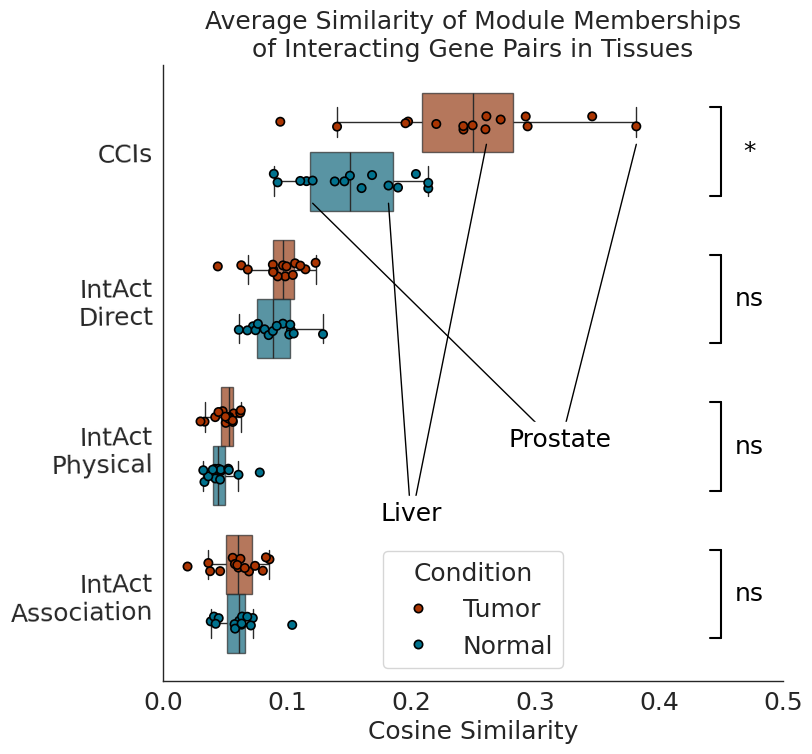

In [23]:
fs = 18  # Font size

# Ensure max_value is defined
order = ['ccc_lr_pairs', 'intact_direct', 'intact_physical', 'intact_association']
labels = ['CCIs', 'IntAct\nDirect', 'IntAct\nPhysical', 'IntAct\nAssociation']

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plot the horizontal boxplot (without outliers)
sns.boxplot(
    data=tissuemeans,
    y="Type",
    x="Value",
    hue="Condition",
    hue_order=["Tumor", "Normal"],
    palette={"Normal": ncolor, "Tumor": tcolor},
    order=order,
    boxprops={"alpha": 0.7},
    showfliers=False,  # Hide outliers
    ax=ax,
    legend=False
)

# Overlay actual data points with jitter for better visibility
sns.stripplot(
    data=tissuemeans,
    y="Type",
    x="Value",
    hue="Condition",
    hue_order=["Tumor", "Normal"],
    palette={"Normal": ncolor, "Tumor": tcolor},
    order=order,
    dodge=True,
    jitter=True,
    size=6,
    edgecolor="black",
    linewidth=1.2,
    ax=ax
)

# ANNOTATE PROSTATE
prostate_points = tissuemeans.query('Tissue == "prostate" and Type == "ccc_lr_pairs"')
text_x = 0.32
text_y = 2

for _, row in prostate_points.iterrows():
    x_value = row["Value"]
    y_value = order.index(row["Type"])  
    offset = 0.35 if row['Condition'] == 'Normal' else -0.05

    ax.plot([x_value, text_x], [y_value + offset, text_y], "black", linestyle='-', linewidth=1, zorder=9)

ax.text(text_x, text_y, "Prostate", fontsize=fs, color="black", ha='center',
        bbox=dict(facecolor="white", edgecolor="white", boxstyle=None), zorder=10)

# ANNOTATE LIVER
liver_points = tissuemeans.query('Tissue == "liver" and Type == "ccc_lr_pairs"')
text_x = 0.2
text_y = 2.5

for _, row in liver_points.iterrows():
    x_value = row["Value"]
    y_value = order.index(row["Type"])
    offset = 0.35 if row['Condition'] == 'Normal' else -0.05

    ax.plot([x_value, text_x], [y_value + offset, text_y], "black", linestyle='-', linewidth=1, zorder=9)

ax.text(text_x, text_y, "Liver", fontsize=fs, color="black", ha='center',
        bbox=dict(facecolor="white", edgecolor="white", boxstyle=None), zorder=10)

# Ensure x-axis starts at 0
ax.set_xlim(0, 0.4)

# Set title
ax.set_title('Average Similarity of Module Memberships\nof Interacting Gene Pairs in Tissues', fontsize=fs)

# Set x-axis label
ax.set_xlabel('Cosine Similarity', fontsize=fs)

# Set y-axis labels
ax.set_yticks(range(len(order)))
ax.set_yticklabels(labels, fontsize=fs, rotation=1, ha='right')

# Remove unnecessary spines
ax.spines[['right', 'top']].set_visible(False)

# Set tick parameters
ax.tick_params(axis='both', which='major', labelsize=fs)

# Adjust legend font size and location
legend = ax.legend(fontsize=fs, loc='lower right')
legend.set_title("Condition", prop={'size': fs})


# Add vertical significance bars

pos = 0.45 # horizontal position of significance bar

for i, interaction_type in enumerate(order):
    # Check if the p-value for the current interaction type is significant
    y_position = i  # Corresponding y-axis position
    pval = pval_adj[interaction_type]

    # Draw significance bar
    ax.plot([pos, pos], [y_position - 0.3, y_position + 0.3], color='black', linestyle='-', zorder=9)
    ax.plot([0.98*pos, pos], [y_position - 0.3, y_position - 0.3], color='black', linestyle='-', zorder=9)
    ax.plot([0.98*pos, pos], [y_position + 0.3, y_position + 0.3], color='black', linestyle='-', zorder=9)
    
    label = 'ns' 
    label = '*' if pval  < 0.05 else label
    label = '**' if pval < 0.01 else label
    
    # Annotate with p-value
    ax.text(1.05*pos, y_position+0.08, f'{label}', fontsize=fs, color='black', ha='center', va='bottom', zorder=10)

# Rest of your plotting code...
# Ensure x-axis starts at 0
ax.set_xlim(0, 0.5)

# Set title
ax.set_title('Average Similarity of Module Memberships\nof Interacting Gene Pairs in Tissues', fontsize=fs)

# Set x-axis label
ax.set_xlabel('Cosine Similarity', fontsize=fs)

# Set y-axis labels
ax.set_yticks(range(len(order)))
ax.set_yticklabels(labels, fontsize=fs, rotation=1, ha='right')

# Remove unnecessary spines
ax.spines[['right', 'top']].set_visible(False)

# Set tick parameters
ax.tick_params(axis='both', which='major', labelsize=fs)

# Adjust legend font size and location
legend = ax.legend(fontsize=fs, loc='lower center')
legend.set_title("Condition", prop={'size': fs})

# Remove ylabel
ax.set_ylabel('')

#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/rewiring/rewiring_boxplot.pdf', dpi=300, bbox_inches='tight')
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/rewiring/rewiring_boxplot.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [24]:
tissues = pivoted_rewiringdf.Tissue.unique()
same_module = pd.read_csv('/home/lnemati/pathway_crosstalk/results/interactions_network/same_module_interactions_all_subtissues.csv')
same_module.loc[same_module.tissue == 'thyroid_gland', 'tissue'] = 'thyroid'
same_module = same_module.query('tissue in @tissues')
same_module = same_module.drop(columns='subtissue')

In [25]:
results = pd.DataFrame(columns=same_module.columns)

for (tissue, condition), dataframe in same_module.groupby(['tissue', 'condition']):
    # Count occurrences in the same module
    mean_counts = dataframe.set_index(['tissue', 'condition']).sum()
    # If more subtissues are present, check if the same module is in at least half of them
    mean_counts = mean_counts >= dataframe.shape[0] / 2
    # Add back tissue and condition
    mean_counts['tissue'] = tissue
    mean_counts['condition'] = condition
    # Concatenate after resetting index
    mean_counts = mean_counts.to_frame().T.reset_index(drop=True)
    results = pd.concat([results, mean_counts], ignore_index=True)
    
results.head()


,tissue,condition,CDH1_ITGA2+ITGB1,CDH1_ITGAE+ITGB7,CDH1_KLRG1,CDH2_FCER2,CADM1_NECTIN3,CADM3_CADM1,CADM3_CADM4,CADM3_EPB41L1,...,LAMA2_ITGA1+ITGB1,LAMA3_ITGA1+ITGB1,LAMA4_ITGA1+ITGB1,LAMA5_ITGA1+ITGB1,LAMB1_ITGA1+ITGB1,LAMB2_ITGA1+ITGB1,LAMB3_ITGA1+ITGB1,LAMC1_ITGA1+ITGB1,LAMC2_ITGA1+ITGB1,LAMC3_ITGA1+ITGB1
0,adrenal_gland,normal,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,adrenal_gland,tumor,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,brain,normal,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,brain,tumor,True,False,False,False,True,True,True,True,...,False,False,True,False,True,False,False,True,False,False
4,breast,normal,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,True,False,False


In [26]:
# Initialize an empty list to store results for each tissue
summary_data = []

# Loop through each tissue and calculate the required values
for tissue, df in results.set_index('condition').groupby('tissue'):
    df = df.drop(columns='tissue')  # Drop the redundant 'tissue' column
    tot = df.shape[1]
    n = df.loc['normal'].sum()
    t = df.loc['tumor'].sum()
    both = sum(df.sum() == 2)
    n_only = n - both
    t_only = t - both
    none = tot - n_only - t_only - both
    
    # Append a dictionary with the calculated values
    summary_data.append({
        'tissue': tissue,
        'tumor_only': t_only,
        'normal_only': n_only,
        'both': both,
        'none': none
    })

# Create a DataFrame from the list of dictionaries
summary_df = pd.DataFrame(summary_data)

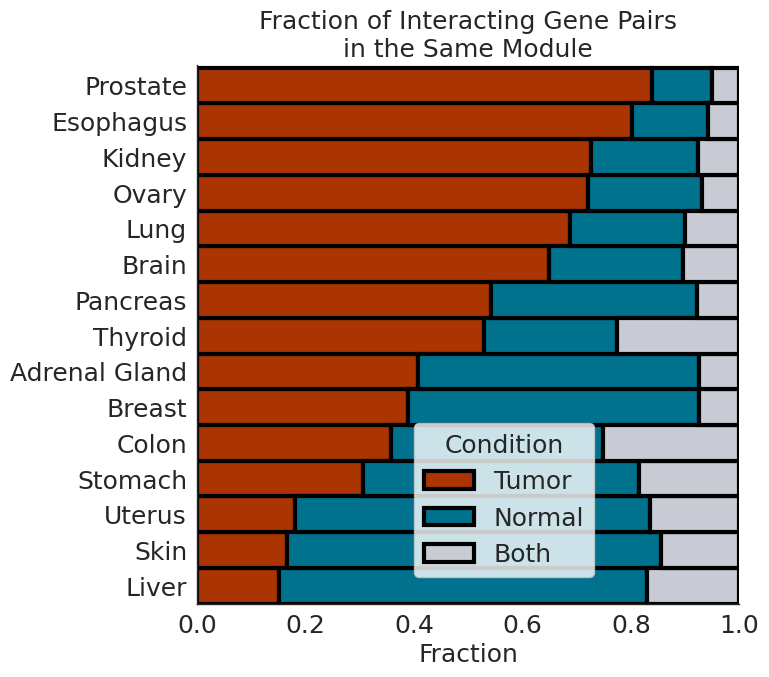

In [27]:
import matplotlib.pyplot as plt
import numpy as np

fs=18

# Ensure tissue names are properly formatted
summary_df['tissue'] = summary_df['tissue'].str.replace('_', ' ').str.title()

# Exclude the 'none' category from calculations
summary_df['total'] = summary_df[['tumor_only', 'normal_only', 'both']].sum(axis=1)
for category in ['tumor_only', 'normal_only', 'both']:
    summary_df[category] = summary_df[category] / summary_df['total']

# Sort the DataFrame by the fraction of 'tumor_only'
summary_df = summary_df.sort_values(by='tumor_only', ascending=True)

# Plotting the horizontal stacked bar plot
categories = ['tumor_only', 'normal_only', 'both']  # Exclude 'none'
category_labels = ['Tumor', 'Normal', 'Both']  # Updated category names
colors = [tcolor, ncolor, lightgray]
tissues = summary_df['tissue']
data = summary_df[categories]

# Plot setup
fig, ax = plt.subplots(figsize=(7, 7))
y_positions = np.arange(len(tissues))

# Plot each category in the stacked bar
bottoms = np.zeros(len(tissues))
for idx, (category, label) in enumerate(zip(categories, category_labels)):
    ax.barh(
        y_positions,
        data[category],
        left=bottoms,
        label=label,
        height=1, # remove all space between bars
        color=colors[idx],  # Custom colors defined externally (tcolor, ncolor, lightgray)
        lw=3,
        edgecolor='k',
    )
    bottoms += data[category]

# Formatting
ax.set_yticks(y_positions)
ax.set_yticklabels(tissues)
ax.set_xlabel('Fraction', fontsize=fs)
ax.set_title('Fraction of Interacting Gene Pairs\nin the Same Module', fontsize=fs)
ax.legend(title='Condition', loc=(0.4, 0.05), title_fontsize=fs, fontsize=fs)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove white space between bars
ax.set_xlim(0, 1)
ax.set_ylim(-0.5, len(tissues) - 0.42)

ax.tick_params(axis='both', which='major', labelsize=fs)

#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/rewiring/same_module_barplot.pdf', dpi=300, bbox_inches='tight')
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/rewiring/same_module_barplot.svg', dpi=300, bbox_inches='tight')
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/rewiring/same_module_barplot.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


In [59]:
median_connect['connection_strength'].loc[pathway_name, 'normal']

0.009985104114833025

# FULL FIGURE

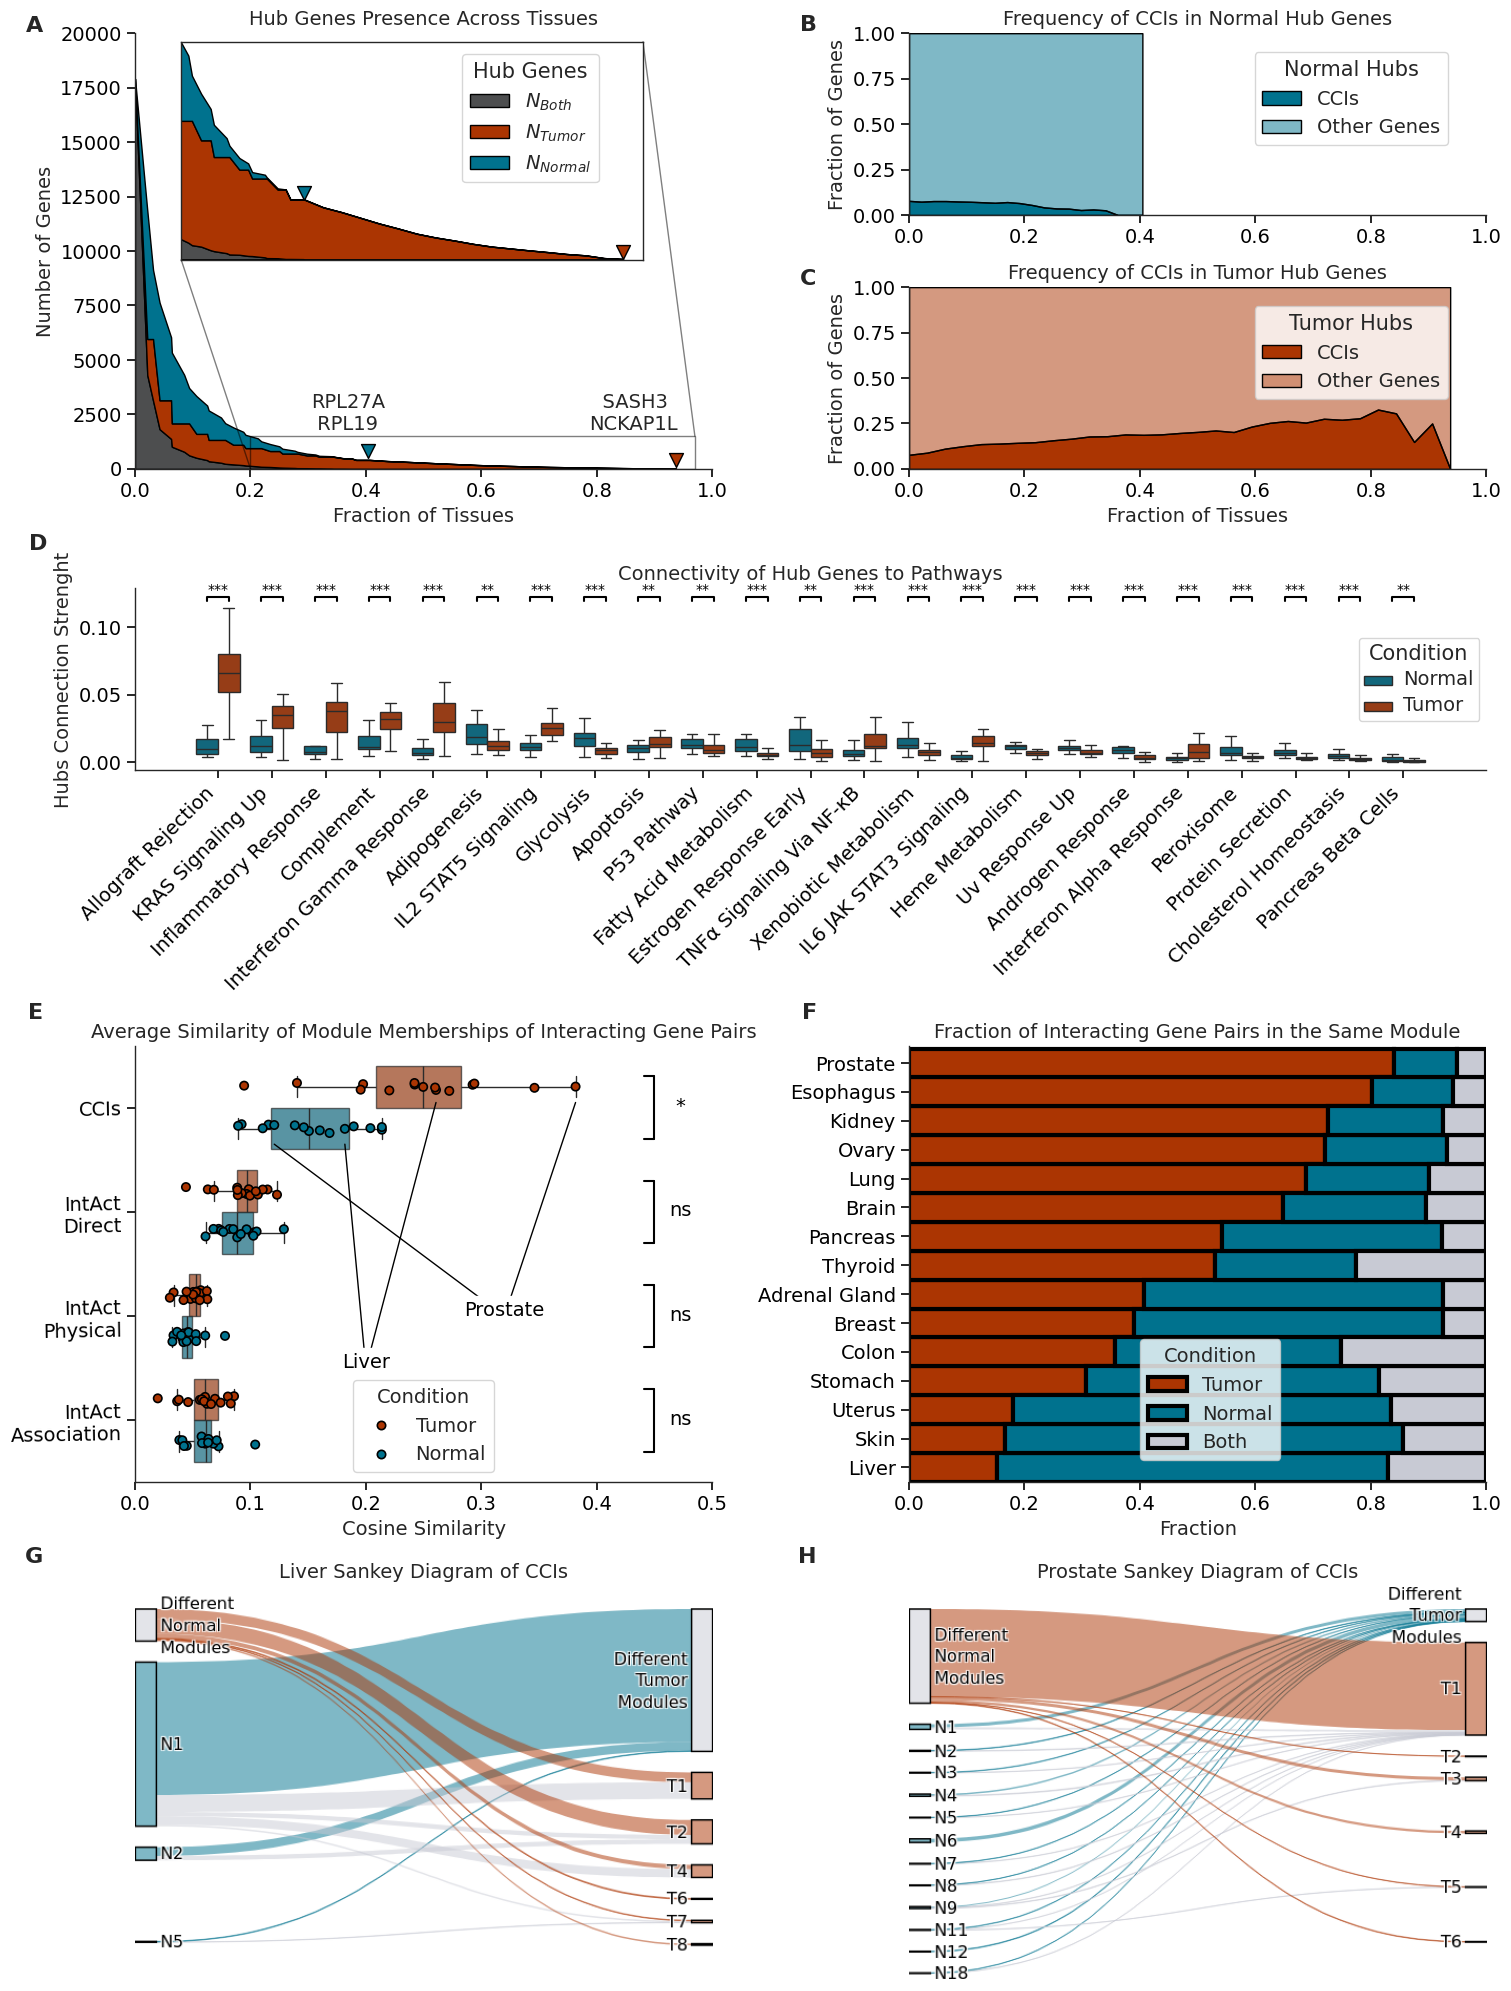

In [63]:
# HUBS FULL FIGURE
from PIL import Image, ImageChops
import matplotlib.image as mpimg

fs = 14

# Create the figure and the layout
fig, axs = plt.subplot_mosaic(
    """
    AB
    AC
    DD
    EF
    EF
    GH
    GH
    """,
    figsize=(15, 20),
    constrained_layout=True
)

# Plot All Hubs using plt.stackplot
axs['A'].stackplot(all_hub_x, all_hub_hubdf['Both'], all_hub_hubdf['Tumor'], all_hub_hubdf['Normal'],
              colors=[graycolor, tcolor, ncolor], edgecolor='black', linewidth=1)

tumor_max = all_hub_hubdf.query('Tumor != 0').index.max()
normal_max = all_hub_hubdf.query('Normal != 0').index.max()

#axs['A'].vlines(x=tumor_max,  ymin=0, ymax=2e4, color=tcolor, linestyle='--')
#axs['A'].vlines(x=normal_max, ymin=0, ymax=2e4, color=ncolor, linestyle='--')
axs['A'].scatter(x=normal_max, y=400+all_hub_hubdf.loc[normal_max].sum(), color=ncolor, s=100, marker='v', edgecolor='k')
axs['A'].scatter(x=tumor_max, y=400+all_hub_hubdf.loc[tumor_max].sum(), color=tcolor, s=100, marker='v', edgecolor='k')
axs['A'].text(x=normal_max-0.1, y=1800, s=nmax_str, fontsize=fs)
axs['A'].text(x=tumor_max-0.15, y=1800, s=tmax_str, fontsize=fs)
axs['A'].set_ylabel('Number of Genes', fontsize=fs)
axs['A'].set_xlabel('Fraction of Tissues', fontsize=fs)
axs['A'].grid(False)

# Add zoom

# subregion of the original image
x1, x2 = 0.2, 0.97,
y1, y2 = 0, 1500
    
axins = axs['A'].inset_axes(
    [0.08, 0.48, 0.8, 0.5],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
axins.stackplot(all_hub_x, all_hub_hubdf['Both'], all_hub_hubdf['Tumor'], all_hub_hubdf['Normal'],
              colors=[graycolor, tcolor, ncolor], edgecolor='black', linewidth=1)
axins.scatter(x=normal_max, y=50+all_hub_hubdf.loc[normal_max].sum(), color=ncolor, s=100, marker='v', edgecolor='k')
axins.scatter(x=tumor_max, y=50+all_hub_hubdf.loc[tumor_max].sum(), color=tcolor, s=100, marker='v', edgecolor='k')
#axins.vlines(x=tumor_max,  ymin=0, ymax=2e4, color=tcolor, linestyle='--')
#axins.vlines(x=normal_max, ymin=0, ymax=2e4, color=ncolor, linestyle='--')

axs['A'].indicate_inset_zoom(axins, edgecolor="black", alpha=0.5)

# Plot Normal Hubs using plt.stackplot
axs['B'].stackplot(normal_hub_x, normal_hub_hubdf['CCIs'], normal_hub_hubdf['Other Genes'],
              colors=[ncolor, ncolor2], edgecolor='black', linewidth=1)
axs['B'].set_ylabel('Fraction of Genes', fontsize=fs)
axs['B'].grid(False)

# Plot Tumor Hubs using plt.stackplot
axs['C'].stackplot(tumor_hub_x, tumor_hub_hubdf['CCIs'], tumor_hub_hubdf['Other Genes'],
              colors=[tcolor, tcolor2], edgecolor='black')
axs['C'].set_xlabel('Fraction of Tissues', fontsize=fs)
axs['C'].set_ylabel('Fraction of Genes', fontsize=fs)
axs['C'].grid(False)

# Plot pathways barplots
#plot_pathway_connectivity_reduced(connect, connect_pvals, significance=0.05, top_N=50, ax=axs['D'])
plot_pathway_connectivity_reduced(connect, connect_pvals, significance=0.01, top_N=50, ax=axs['D'])

labels = [tick.get_text() for tick in axs['D'].get_xticklabels()]
labels = [label.replace('HALLMARK_', '').replace('_', ' ').title() for label in labels]
replace = {
    'Myc': 'MYC',
    'Kras': 'KRAS',
    'Il2': 'IL2',
    'Stat5': 'STAT5',
    'Il6': 'IL6',
    'Jak': 'JAK',
    'Stat3': 'STAT3',
    'P53': 'P53',
    'Tnfa': 'TNFα',
    'Nfkb': 'NF-κB',
    'Mtorc1': 'mTORC1',
    'Mtorc': 'mTORC',
    'Mtor': 'mTOR',
    ' Dn': ' Down',
    'Pi3K': 'PI3K',
    ' Akt': ' AKT',
    'Epithelial Mesenchymal Transition': 'E-M Transition'
}
for str1, str2 in replace.items():
    labels = [label.replace(str1, str2) for label in labels]
axs['D'].set_xticklabels(labels)

# Color y-axis labels
#y_labels = ax.get_yticklabels()
#for i, label in enumerate(y_labels):
#    label.set_color(tcolor if i < N else ncolor)


median_connect = connect.groupby(['Pathway', 'Condition']).median()
# convert pathway names to match xlabels
orig_names = median_connect.index.get_level_values('Pathway').to_list()
new_names = [name.replace('HALLMARK_', '').replace('_', ' ').title() for name in orig_names]
for str1, str2 in replace.items():
    new_names = [name.replace(str1, str2) for name in new_names]
median_connect.index = pd.MultiIndex.from_tuples(
    [(name, cond) for name, cond in zip(new_names, median_connect.index.get_level_values('Condition'))],
    names=['Pathway', 'Condition']
)    

# Add legends
loc = 'upper right'
axs['A'].legend(['$N_{Both}$', '$N_{Tumor}$', '$N_{Normal}$'], title='Hub Genes', bbox_to_anchor=(0.82, 0.975), loc=loc, fontsize=fs)
axs['B'].legend(['CCIs', 'Other Genes'], title='Normal Hubs', bbox_to_anchor=(0.95, 0.95), loc=loc, fontsize=fs)
axs['C'].legend(['CCIs', 'Other Genes'], title='Tumor Hubs', bbox_to_anchor=(0.95, 0.95), loc=loc, fontsize=fs)
axs['D'].legend(title='Condition', loc='center right')


axs['A'].set_xlim(0, 1)
axs['B'].set_xlim(0, 1)
axs['C'].set_xlim(0, 1)

axs['A'].set_ylim(0, 20000)
axs['B'].set_ylim(0, 1.)
axs['C'].set_ylim(0, 1.)

for ax in axs:
    axs[ax].spines[['right', 'top']].set_visible(False)

    axs[ax].xaxis.set_ticks_position('bottom')
    axs[ax].yaxis.set_ticks_position('left')
    axs[ax].get_xaxis().set_visible(True)
    axs[ax].get_yaxis().set_visible(True)

    axs[ax].tick_params(
        axis='both',
        which='both',
        labelsize=fs,
        direction='out',
        length=6,
        width=1.2,
        colors='black'
    )
    
#axs['D'].tick_params(labelrotation=45)
for label in axs['D'].get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')  # Align to the right for better spacing

axs['D'].set_xlabel('')

axs['A'].set_title('Hub Genes Presence Across Tissues', fontsize=fs)
axs['B'].set_title('Frequency of CCIs in Normal Hub Genes', fontsize=fs)
axs['C'].set_title('Frequency of CCIs in Tumor Hub Genes', fontsize=fs)
axs['D'].set_title('Connectivity of Hub Genes to Pathways', fontsize=fs)

legend = axs['D'].get_legend()
#axs['D'].set_xlabel('Pathway', fontsize=fs)
axs['D'].set_ylabel('Hubs Connection Strenght', fontsize=fs)

if legend:
    for text in legend.get_texts():
        text.set_text(text.get_text().capitalize())
        text.set_fontsize(fs)

# Ensure max_value is defined
order = ['ccc_lr_pairs', 'intact_direct', 'intact_physical', 'intact_association']
labels = ['CCIs', 'IntAct\nDirect', 'IntAct\nPhysical', 'IntAct\nAssociation']

################################## Panel E: Rewiring Boxplot
ax = axs['E']

# Plot the horizontal boxplot (without outliers)
sns.boxplot(
    data=tissuemeans,
    y="Type",
    x="Value",
    hue="Condition",
    hue_order=["Tumor", "Normal"],
    palette={"Normal": ncolor, "Tumor": tcolor},
    order=order,
    boxprops={"alpha": 0.7},
    showfliers=False,  # Hide outliers
    ax=ax,
    legend=False
)

# Overlay actual data points with jitter for better visibility
sns.stripplot(
    data=tissuemeans,
    y="Type",
    x="Value",
    hue="Condition",
    hue_order=["Tumor", "Normal"],
    palette={"Normal": ncolor, "Tumor": tcolor},
    order=order,
    dodge=True,
    jitter=True,
    size=6,
    edgecolor="black",
    linewidth=1.2,
    ax=ax
)

# Annotate Prostate
prostate_points = tissuemeans.query('Tissue == "prostate" and Type == "ccc_lr_pairs"')
text_x = 0.32
text_y = 2

for _, row in prostate_points.iterrows():
    x_value = row["Value"]
    y_value = order.index(row["Type"])  
    offset = 0.35 if row['Condition'] == 'Normal' else -0.05
    ax.plot([x_value, text_x], [y_value + offset, text_y], "black", linestyle='-', linewidth=1, zorder=9)

ax.text(text_x, text_y, "Prostate", fontsize=fs, color="black", ha='center',
        bbox=dict(facecolor="white", edgecolor="white", boxstyle=None), zorder=10)

# Annotate Liver
liver_points = tissuemeans.query('Tissue == "liver" and Type == "ccc_lr_pairs"')
text_x = 0.2
text_y = 2.5

for _, row in liver_points.iterrows():
    x_value = row["Value"]
    y_value = order.index(row["Type"])
    offset = 0.35 if row['Condition'] == 'Normal' else -0.05
    ax.plot([x_value, text_x], [y_value + offset, text_y], "black", linestyle='-', linewidth=1, zorder=9)

ax.text(text_x, text_y, "Liver", fontsize=fs, color="black", ha='center',
        bbox=dict(facecolor="white", edgecolor="white", boxstyle=None), zorder=10)

# Final formatting
ax.set_xlim(0, 0.5)
ax.set_title('Average Similarity of Module Memberships of Interacting Gene Pairs', fontsize=fs)
ax.set_xlabel('Cosine Similarity', fontsize=fs)
ax.set_ylabel('')
ax.set_yticks(range(len(order)))
ax.set_yticklabels(labels, fontsize=fs, rotation=1, ha='right')
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=fs)

# Adjust legend
legend = ax.legend(fontsize=fs, loc='lower center')
legend.set_title("Condition", prop={'size': fs})

# Add vertical significance bars
pos = 0.45
for i, interaction_type in enumerate(order):
    y_position = i
    pval = pval_adj[interaction_type]
    ax.plot([pos, pos], [y_position - 0.3, y_position + 0.3], color='black', linestyle='-', zorder=9)
    ax.plot([0.98 * pos, pos], [y_position - 0.3, y_position - 0.3], color='black', zorder=9)
    ax.plot([0.98 * pos, pos], [y_position + 0.3, y_position + 0.3], color='black', zorder=9)

    label = '**' if pval < 0.01 else '*' if pval < 0.05 else 'ns'
    ax.text(1.05 * pos, y_position + 0.08, f'{label}', fontsize=fs, color='black', ha='center', va='bottom', zorder=10)


############################### Panel F: Same Module Barplot

# Plot setup
ax = axs['F']
y_positions = np.arange(len(tissues))

# Plot each category in the stacked bar
bottoms = np.zeros(len(tissues))
for idx, (category, label) in enumerate(zip(categories, category_labels)):
    ax.barh(
        y_positions,
        data[category],
        left=bottoms,
        label=label,
        height=1, # remove all space between bars
        color=colors[idx],  # Custom colors defined externally (tcolor, ncolor, lightgray)
        lw=3,
        edgecolor='k',
    )
    bottoms += data[category]

# Formatting
ax.set_yticks(y_positions)
ax.set_yticklabels(tissues)
ax.set_xlabel('Fraction', fontsize=fs)
ax.set_title('Fraction of Interacting Gene Pairs in the Same Module', fontsize=fs)
ax.legend(title='Condition', loc=(0.4, 0.05), title_fontsize=fs, fontsize=fs)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove white space between bars
ax.set_xlim(0, 1)
ax.set_ylim(-0.5, len(tissues) - 0.42)

ax.tick_params(axis='both', which='major', labelsize=fs)


def manual_crop_asymmetric(
    img: Image.Image,
    crop_left: int = 0,
    crop_right: int = 0,
    crop_top: int = 0,
    crop_bottom: int = 0
) -> Image.Image:
    """Crop specific pixels from each side."""
    width, height = img.size
    left = crop_left
    right = width - crop_right
    top = crop_top
    bottom = height - crop_bottom
    return img.crop((left, top, right, bottom))

# Define crop values
crop_left = 75
crop_right = crop_left
crop_top = 78
crop_bottom = 46


############# Panel G: Sankey Image - Liver (asymmetric crop) ##############

ax = axs['G']
img_path_liver = "/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/liver/tumor/liver_hepatocellular_carcinoma/figures/sankey.png"

img_liver = Image.open(img_path_liver).convert("RGB")
img_liver_cropped = manual_crop_asymmetric(
    img_liver,
    crop_left=crop_left,
    crop_right=crop_right,
    crop_top=crop_top,
    crop_bottom=crop_bottom
)
ax.imshow(img_liver_cropped)
ax.axis('off')
ax.set_title("Liver Sankey Diagram of CCIs", fontsize=fs)


############# AXIS H: Sankey Image - Prostate (asymmetric crop) ##############

ax = axs['H']
img_path_prostate = "/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/prostate/tumor/prostate_adenocarcinoma/figures/sankey.png"

img_prostate = Image.open(img_path_prostate).convert("RGB")
img_prostate_cropped = manual_crop_asymmetric(
    img_prostate,
    crop_left=crop_left,
    crop_right=crop_right,
    crop_top=crop_top,
    crop_bottom=crop_bottom
)
ax.imshow(img_prostate_cropped)
ax.axis('off')
ax.set_title("Prostate Sankey Diagram of CCIs", fontsize=fs)





# Color x-axis of boxplot based on wether tumor or normal wins in connect
#xlabels = axs['D'].get_xticklabels()
#for i, label in enumerate(xlabels):
#    pathway_name = label.get_text()
#    if pathway_name in median_connect.index.get_level_values('Pathway'):
#        tvalue = median_connect.loc[pathway_name, 'tumor']
#        color = tcolor if median_connect['connection_strength'].loc[pathway_name, 'tumor'] > median_connect['connection_strength'].loc[pathway_name, 'normal'] else ncolor
#        label.set_color(color)




# Panel A: Hubs
ax = axs['A']
ax.text(-0.16, 1.04, 'A', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right')

# Panel B: Hubs CCIs Normal
ax = axs['B']
ax.text(-0.16, 1.1, 'B', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right')

# Panel C: Hubs CCIs Tumor
ax = axs['C']
ax.text(-0.16, 1.1, 'C', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right')

# Panel D: Hallmarks
ax = axs['D']
ax.text(-0.065, 1.3, 'D', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right')

# Panel E: Rewiring Boxplot
ax = axs['E']
ax.text(-0.16, 1.1, 'E', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right')

# Panel F: Same Module Barplot
ax = axs['F']
ax.text(-0.16, 1.1, 'F', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right')

# Panel G: Sankey Liver
ax = axs['G']
ax.text(-0.16, 1.1, 'G', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right')

# Panel H: Sankey Prostate
ax = axs['H']
ax.text(-0.16, 1.1, 'H', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right')

#fig.subplots_adjust(hspace=0.1)  # Increase the vertical spacing between subplots
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig3/fig3.svg', bbox_inches='tight', dpi=300)
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig3/fig3.pdf', bbox_inches='tight', dpi=300)
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig3/fig3.png', bbox_inches='tight', dpi=300)
plt.show()

In [74]:
#fig_to_panels(fig, axs, output_dir='/home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig3/panels')

Saved panel 'Hub Genes Presence Across Tissues' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig3/panels/hub_genes_presence_across_tissues
Saved panel 'Frequency of CCIs in Normal Hub Genes' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig3/panels/frequency_of_ccis_in_normal_hub_genes
Saved panel 'Frequency of CCIs in Tumor Hub Genes' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig3/panels/frequency_of_ccis_in_tumor_hub_genes
Saved panel 'Connectivity of Hub Genes to Pathways' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig3/panels/connectivity_of_hub_genes_to_pathways


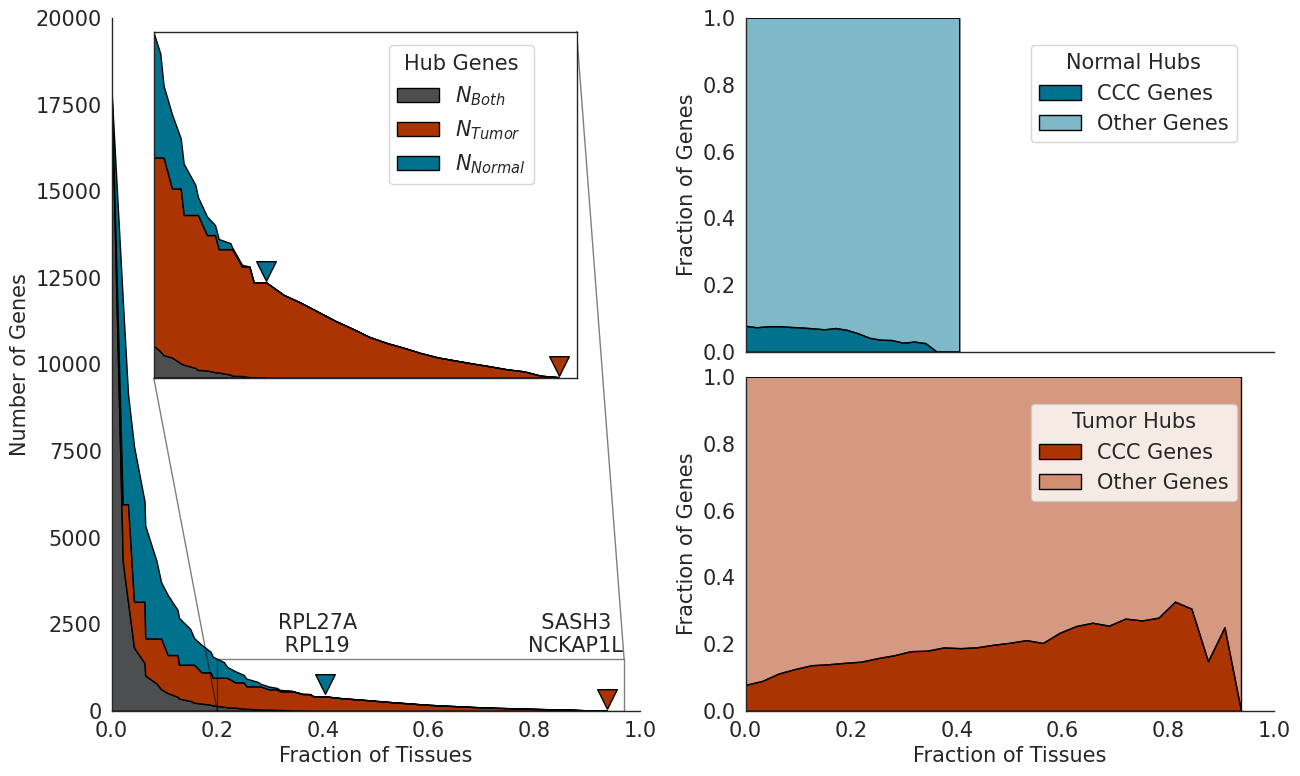

In [322]:
# HUBS FULL FIGURE

fs = 15

# Create the figure and the layout
fig = plt.figure(figsize=(15, 9))
axs = fig.subplot_mosaic(
    """
    AB
    AC
    """
)

# Plot All Hubs using plt.stackplot
axs['A'].stackplot(all_hub_x, all_hub_df['Both'], all_hub_df['Tumor'], all_hub_df['Normal'],
              colors=[graycolor, tcolor, ncolor], edgecolor='black', linewidth=1)

tumor_max = all_hub_df.query('Tumor != 0').index.max()
normal_max = all_hub_df.query('Normal != 0').index.max()

#axs['A'].vlines(x=tumor_max,  ymin=0, ymax=2e4, color=tcolor, linestyle='--')
#axs['A'].vlines(x=normal_max, ymin=0, ymax=2e4, color=ncolor, linestyle='--')
axs['A'].scatter(x=normal_max, y=325+all_hub_df.loc[normal_max].sum(), color=ncolor, s=200, marker='v', edgecolor='k')
axs['A'].scatter(x=tumor_max, y=325+all_hub_df.loc[tumor_max].sum(), color=tcolor, s=200, marker='v', edgecolor='k')
axs['A'].text(x=normal_max-0.09, y=1700, s=nmax_str, fontsize=fs)
axs['A'].text(x=tumor_max-0.15, y=1700, s=tmax_str, fontsize=fs)
axs['A'].set_ylabel('Number of Genes', fontsize=fs)
axs['A'].set_xlabel('Fraction of Tissues', fontsize=fs)
axs['A'].grid(False)

# Add zoom

# subregion of the original image
x1, x2 = 0.2, 0.97,
y1, y2 = 0, 1500
    
axins = axs['A'].inset_axes(
    [0.08, 0.48, 0.8, 0.5],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
axins.stackplot(all_hub_x, all_hub_df['Both'], all_hub_df['Tumor'], all_hub_df['Normal'],
              colors=[graycolor, tcolor, ncolor], edgecolor='black', linewidth=1)
axins.scatter(x=normal_max, y=50+all_hub_df.loc[normal_max].sum(), color=ncolor, s=200, marker='v', edgecolor='k')
axins.scatter(x=tumor_max, y=50+all_hub_df.loc[tumor_max].sum(), color=tcolor, s=200, marker='v', edgecolor='k')
#axins.vlines(x=tumor_max,  ymin=0, ymax=2e4, color=tcolor, linestyle='--')
#axins.vlines(x=normal_max, ymin=0, ymax=2e4, color=ncolor, linestyle='--')

axs['A'].indicate_inset_zoom(axins, edgecolor="black", alpha=0.5)

# Plot Normal Hubs using plt.stackplot
axs['B'].stackplot(normal_hub_x, normal_hub_df['CCC'], normal_hub_df['Other Genes'],
              colors=[ncolor, ncolor2], edgecolor='black', linewidth=1)
axs['B'].set_ylabel('Fraction of Genes', fontsize=fs)
axs['B'].grid(False)

# Plot Tumor Hubs using plt.stackplot
axs['C'].stackplot(tumor_hub_x, tumor_hub_df['CCC'], tumor_hub_df['Other Genes'],
              colors=[tcolor, tcolor2], edgecolor='black')
axs['C'].set_xlabel('Fraction of Tissues', fontsize=fs)
axs['C'].set_ylabel('Fraction of Genes', fontsize=fs)
axs['C'].grid(False)

# Add legends
loc = 'upper right'
axs['A'].legend(['$N_{Both}$', '$N_{Tumor}$', '$N_{Normal}$'], title='Hub Genes', bbox_to_anchor=(0.82, 0.975), loc=loc, fontsize=fs)
axs['B'].legend(['CCIs', 'Other Genes'], title='Normal Hubs', bbox_to_anchor=(0.95, 0.95), loc=loc, fontsize=fs)
axs['C'].legend(['CCIs', 'Other Genes'], title='Tumor Hubs', bbox_to_anchor=(0.95, 0.95), loc=loc, fontsize=fs)


axs['A'].set_xlim(0, 1)
axs['B'].set_xlim(0, 1)
axs['C'].set_xlim(0, 1)

axs['A'].set_ylim(0, 20000)
axs['B'].set_ylim(0, 1.)
axs['C'].set_ylim(0, 1.)

for ax in axs:
    axs[ax].spines[['right', 'top']].set_visible(False)
    axs[ax].tick_params(labelsize=fs)
    
fig.subplots_adjust(hspace=0.075)  # Increase the vertical spacing between subplots
axs['B'].set_xticks([])

plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/hubs/hubs_subset_figure.pdf', bbox_inches='tight')
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/hubs/hubs_subset_figure.png', bbox_inches='tight')
plt.show()